# Cleaning MoMA Dataset (Kaggle)

In [1]:
install.packages("tidyverse", repos='http://cran.us.r-project.org')
install.packages("fuzzyjoin", repos='http://cran.us.r-project.org')
install.packages("fedmatch", repos='http://cran.us.r-project.org')
install.packages("tm", repos='http://cran.us.r-project.org')

Installing package into 'C:/Users/reedc/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'tidyverse' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\reedc\AppData\Local\Temp\RtmpE9kzVA\downloaded_packages


Installing package into 'C:/Users/reedc/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)

also installing the dependencies 'stringdist', 'geosphere'




package 'stringdist' successfully unpacked and MD5 sums checked
package 'geosphere' successfully unpacked and MD5 sums checked
package 'fuzzyjoin' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\reedc\AppData\Local\Temp\RtmpE9kzVA\downloaded_packages


Installing package into 'C:/Users/reedc/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)

also installing the dependencies 'SnowballC', 'BH'




package 'SnowballC' successfully unpacked and MD5 sums checked
package 'BH' successfully unpacked and MD5 sums checked
package 'fedmatch' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\reedc\AppData\Local\Temp\RtmpE9kzVA\downloaded_packages


Installing package into 'C:/Users/reedc/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)

also installing the dependencies 'NLP', 'slam'




package 'NLP' successfully unpacked and MD5 sums checked
package 'slam' successfully unpacked and MD5 sums checked
package 'tm' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\reedc\AppData\Local\Temp\RtmpE9kzVA\downloaded_packages


In [2]:
library(tidyverse)
library(fuzzyjoin)
library(fedmatch)
library(stringr)
library(stringi)
library(tm)

Warning message:
"package 'tidyverse' was built under R version 4.3.3"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'fuzzyjoin' was built under R version 4.3.3"
Warning message:
"package 'fedmatch' was built under R version 4.3.3"
Warning message:
"package 'tm' was built under R version 4.3.3"
Loading required package: NLP


Attaching package: 'NLP'


The following object is masked from 'package:ggplot2':

    annotate




In [4]:
# --- --- --- --- --- --- --- --- --- #
#  -   -   - Data Collection -  -  -  #
# --- --- --- --- --- --- --- --- --- #

# --- Import Data*
moma_artists <- read.csv('../../data/moma/kaggle/moma_artists.csv')
moma_objects <- read.csv('../../data/moma/kaggle/moma_objects.csv')
countries <- read.csv('../../data/standards/countries.csv')

# --- Merge artworks & artists tables on 'Artist ID'
moma_works <- merge(x = moma_artists, y = moma_objects, by = "Artist_ID")

# --- Merge moma_works & countries tables on 'Nationality'
moma_countries <- merge(x = moma_works, y = countries, by = "Nationality")

# --- Select MoMA data into DF
moma_df <- moma_countries %>%
    select(Nationality, Artist_ID, Gender, Birth_Year, 
           Artwork_ID, Title, Artist_Name, Date, Medium,
           Acquisition_Date, Classification, Country, 
           Region, Sub_Region)

In [13]:
# Merge artworks & artists tables on 'Artist ID'
moma_works <- merge(x = moma_artists, y = moma_objects, by = "Artist_ID")

# Merge moma_works & countries tables on 'Nationality'
moma_countries <- merge(x = moma_works, y = countries, by = "Nationality")

# Select MoMA data into DF
moma_df <- moma_countries %>%
    select(Artwork_ID, Title, Date, 
           Classification, Medium, Acquisition_Date,
           Nationality, Country, Region, Sub_Region, 
           Artist_ID, Artist_Name, Gender, Birth_Year)

In [14]:
# --- --- --- --- --- --- --- --- --- --- --- #
#  -   -   -   Data Cleaning  -   -   -   -   #
# --- --- --- --- --- --- --- --- --- --- --- #

# --- Convert all data in 'Gender' column to lowercase
moma_df$Gender <- tolower(moma_df$Gender)

# --- Filter 'DATE' column into 'Object_Year' column as integer year
moma_df$Object_Year <- moma_df$Date

dtemp <- moma_df$Object_Year

i = 1

# --- Iterate over temp values from 'Object_Year' column
while (i <= length(dtemp)) {

  # --- Convert value to '0' if empty
  if (is.na(dtemp[i]) | dtemp[i] == '') {
    moma_df$Object_Year[i] = '0'
  
    # --- Check value for 4-digit year
    } else {
      o <- nchar(dtemp[i])
      
      # --- Work backwards across the string
      # --- Search 4-character string of numbers
      while (o >= 4) {
        a <- (o - 3)
        s <- substr(dtemp[i], a, o)
        
        # --- Extract 4-digit year if found
        if (!grepl("\\D", s)) {
          moma_df$Object_Year[i] = s
          break
        
          # --- Set value to '0' if no 4-digit year found
          } else if (grepl("\\D", s) & o == 4) {
            moma_df$Object_Year[i] = '0'
        }
        
        # --- Decrement substring 'stop' value
        o = o - 1
      }
    }
  
  # --- Increment along temp column
  i = i + 1
}

# --- Convert 'Object_Year' values from strings to integers
moma_df$Object_Year <- as.integer(moma_df$Object_Year)


# --- Check 'NATIONALITY' column, set 'unknown' values
ntemp <- moma_df$Nationality

j = 1

# --- Iterate over temp 'Nationality' values
while (j <= length(ntemp)) {
  
  # --- Label missing values as 'Unknown'
  if (is.na(ntemp[j]) | ntemp[j] == '') {
    moma_df$Nationality[j] = 'Unknown'
    
    # --- Standardize all labels containing the word 'unknown'
  } else if (str_detect(tolower(ntemp[j]), 'unknown')) {
    moma_df$Nationality[j] = 'Unknown'
  }
  
  j = j + 1
}

# --- Check 'CLASSIFICATION' column, set 'not assigned' values
# cc <- table(moma_df$Classification)
# print(cc)

ctemp <- moma_df$Classification

k = 1

# --- Iterate over temp 'Classification' values
while (k <= length(ctemp)) {
  
  # --- Label missing values as 'Unassigned'
  if (is.na(ctemp[k]) | ctemp[k] == '') {
    moma_df$Classification[k] = 'Unassigned'
    
    # --- Rename all labels containing keywords 'not assigned' to 'Unassigned'
  } else if (str_detect(tolower(ctemp[k]), 'not assigned')) {
    moma_df$Classification[k] = 'Unassigned'
  
    # --- Rename 'Film object' to 'Film'
    } else if (str_detect(tolower(ctemp[k]), 'object')) {
    moma_df$Classification[k] = 'Film'
  }
  
  k = k + 1
}


Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"


In [15]:
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- #
#  -   -  Most and Least Represented Nationalities  -  -  #
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- #

# --- Count number of works per nationality
natl <- table(moma_df$Nationality)

# --- First 25, 50, & 75 Nationalities by No. of pieces in collection
first_25_natl <- c(head(sort(natl, decreasing=TRUE), n=25))
first_50_natl <- c(head(sort(natl, decreasing=TRUE), n=50))
first_75_natl <- c(head(sort(natl, decreasing=TRUE), n=75))

# --- Last 25 & 50 Nationalities by No. of pieces in collection
last_25_natl <- c(head(sort(natl, decreasing=FALSE), n=25))
last_50_natl <- c(head(sort(natl, decreasing=FALSE), n=50))

# --- First 25, 50, & 75 Nationalities (incl. 'Unknown' & 'Various')
first_25_names <- c(names(first_25_natl))
first_50_names <- c(names(first_50_natl))
first_75_names <- c(names(first_75_natl))

# --- Last 25 & 50 Nationalities (incl. 'Unknown' & 'Various')
last_25_names <- c(names(last_25_natl))
last_50_names <- c(names(last_50_natl))

# --- Create DFs with artwork from 25, 50, & 75 most represented nationalities at MoMA
first_25_df <- moma_df %>% 
  filter(Nationality %in% first_25_names)

first_50_df <- moma_df %>% 
  filter(Nationality %in% first_50_names)

first_75_df <- moma_df %>% 
  filter(Nationality %in% first_75_names)

# --- Create DFs with artwork from 25 & 50 least represented nationalities at MoMA
last_25_df <- moma_df %>% 
  filter(Nationality %in% last_25_names)

last_50_df <- moma_df %>% 
  filter(Nationality %in% last_50_names)


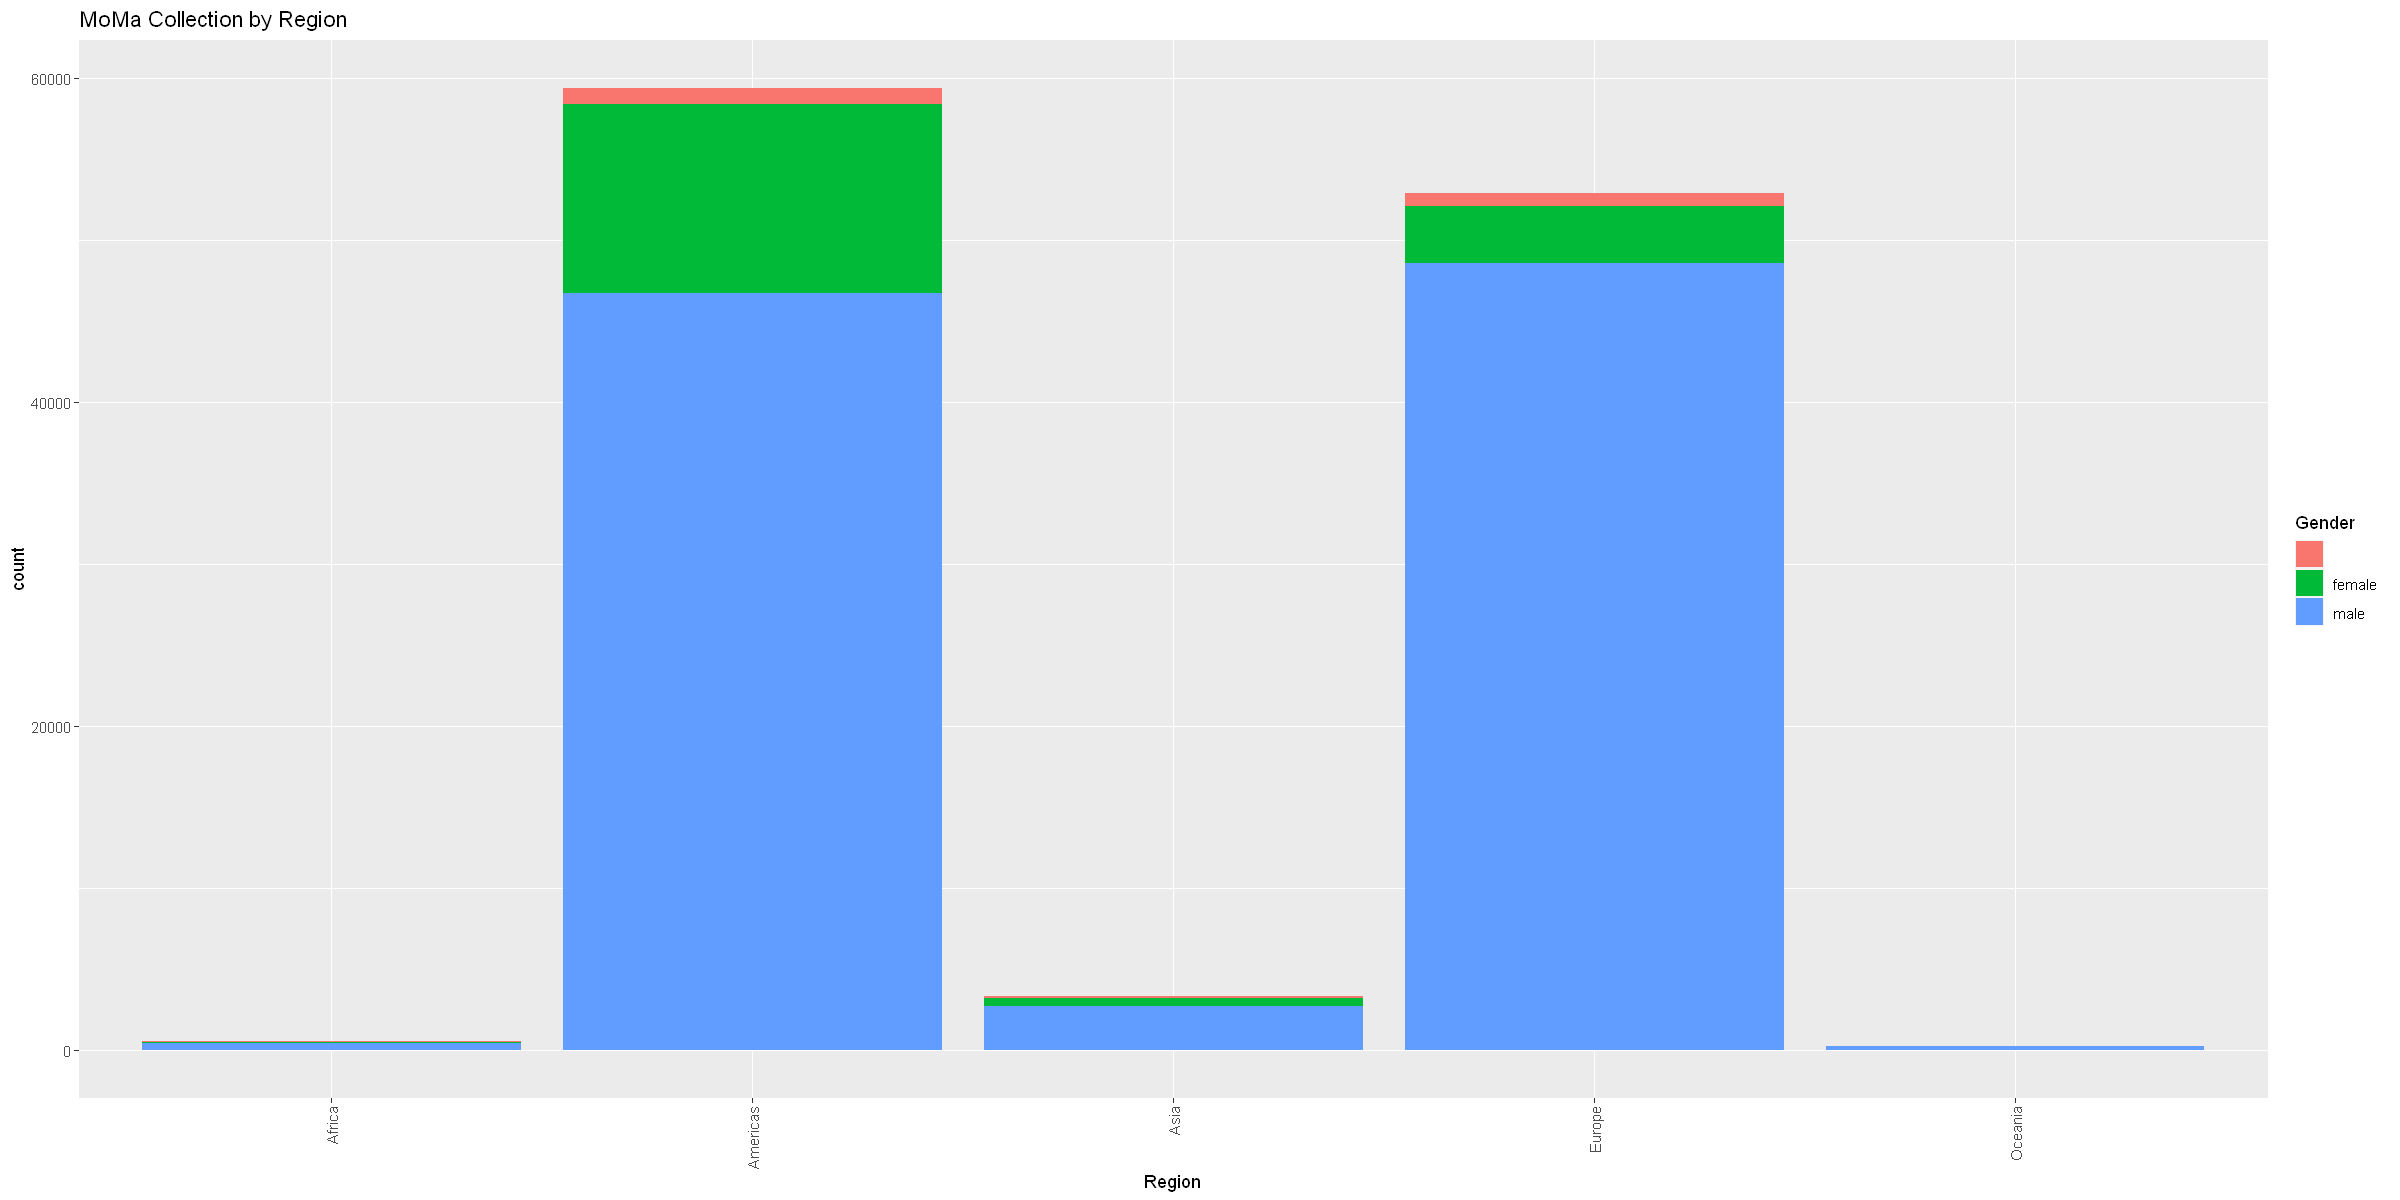

Warning message:
"Removed 2454 rows containing missing values (`geom_point()`)."


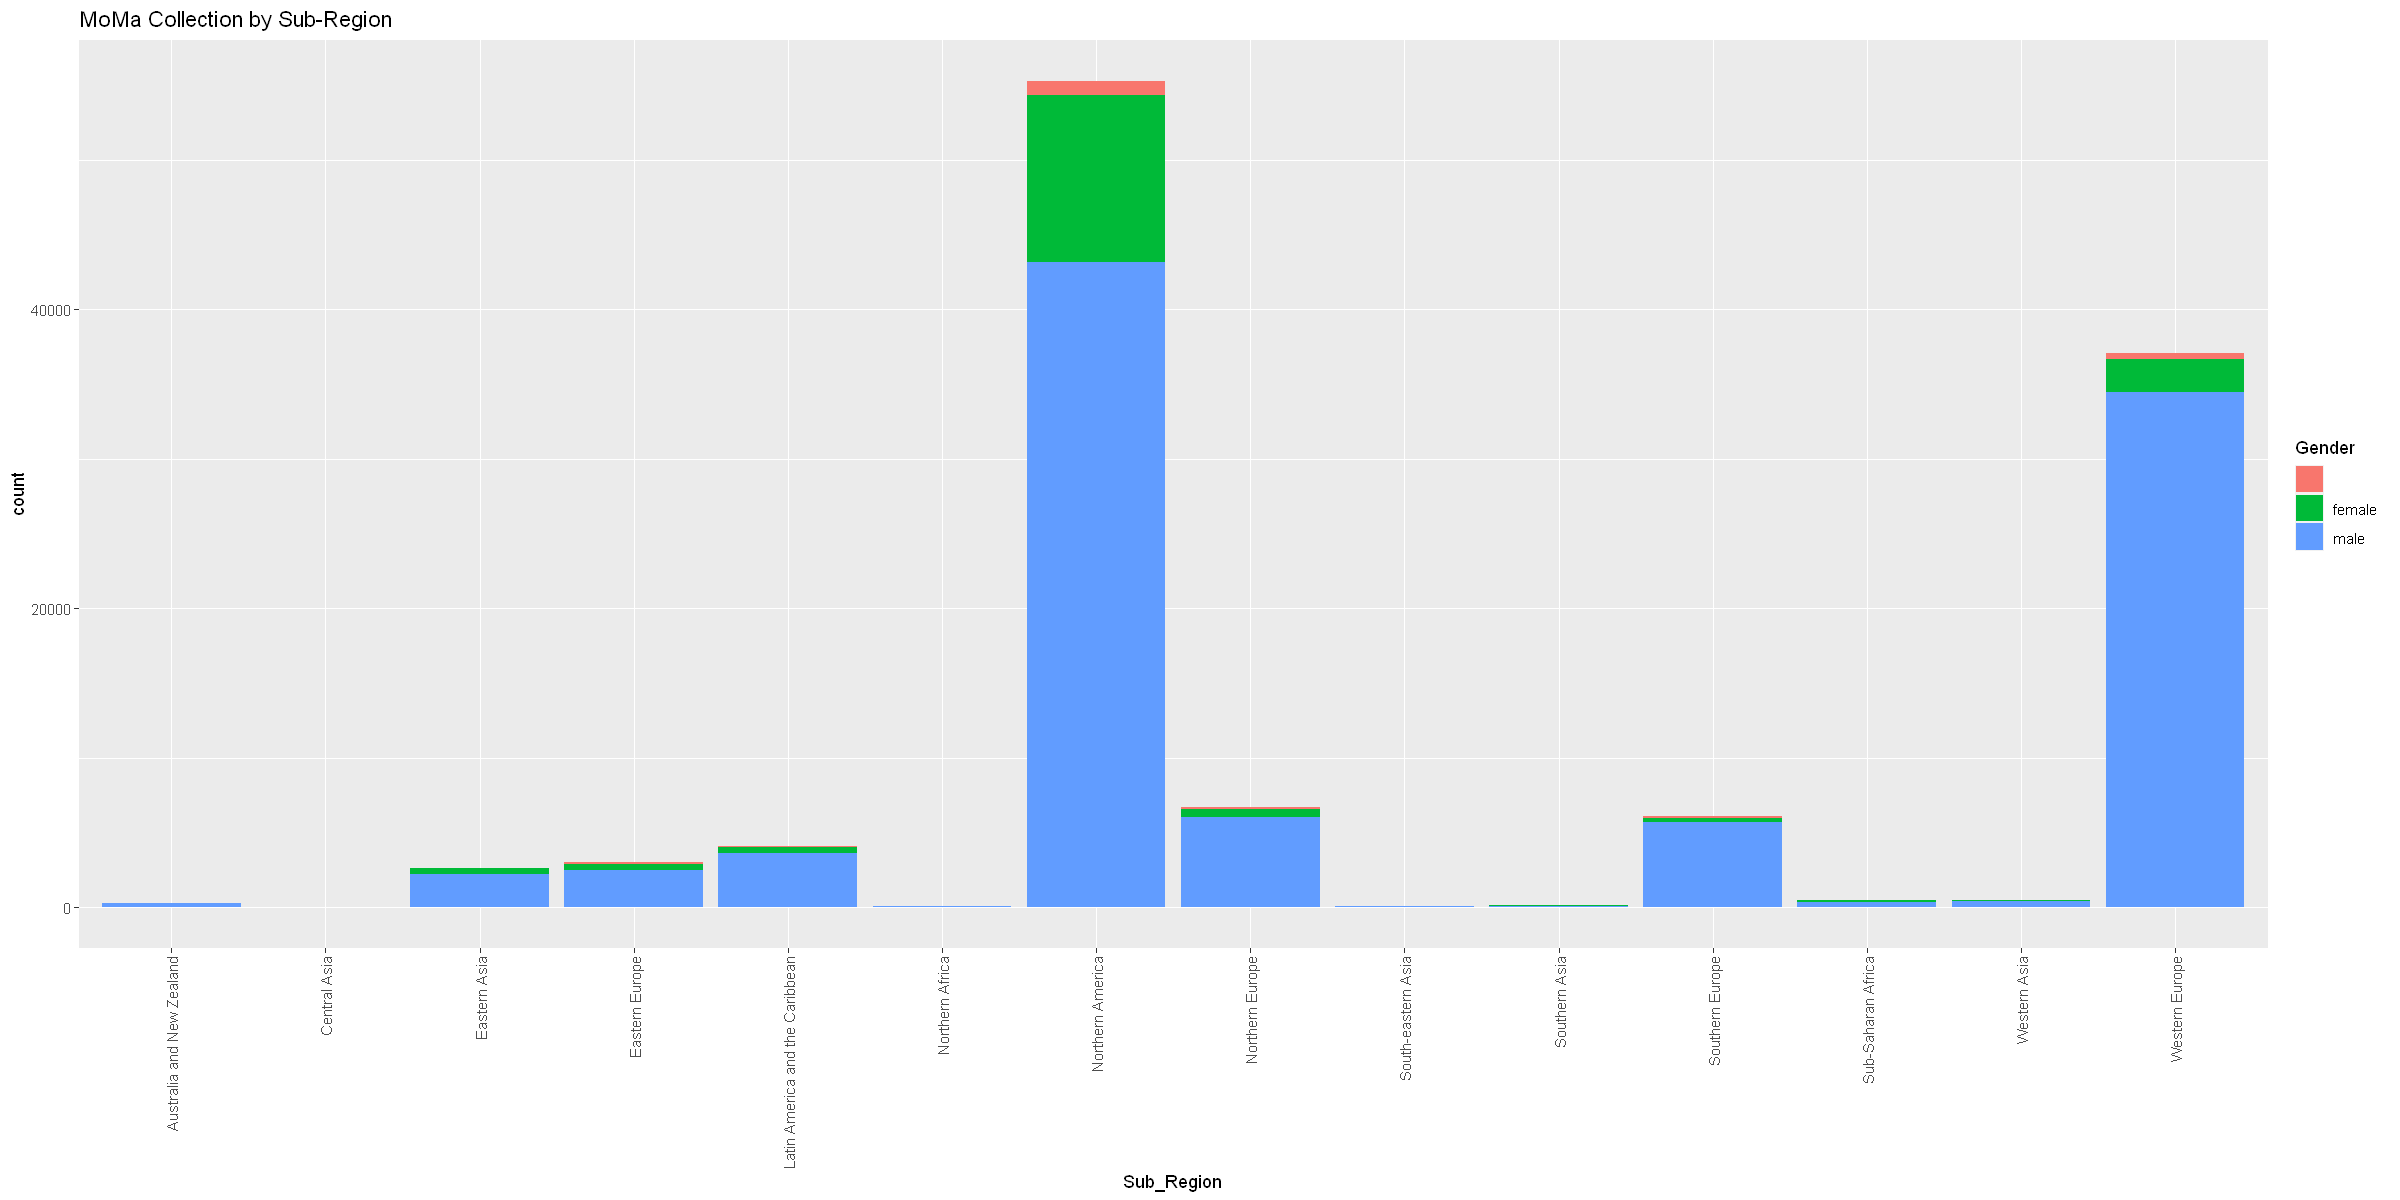

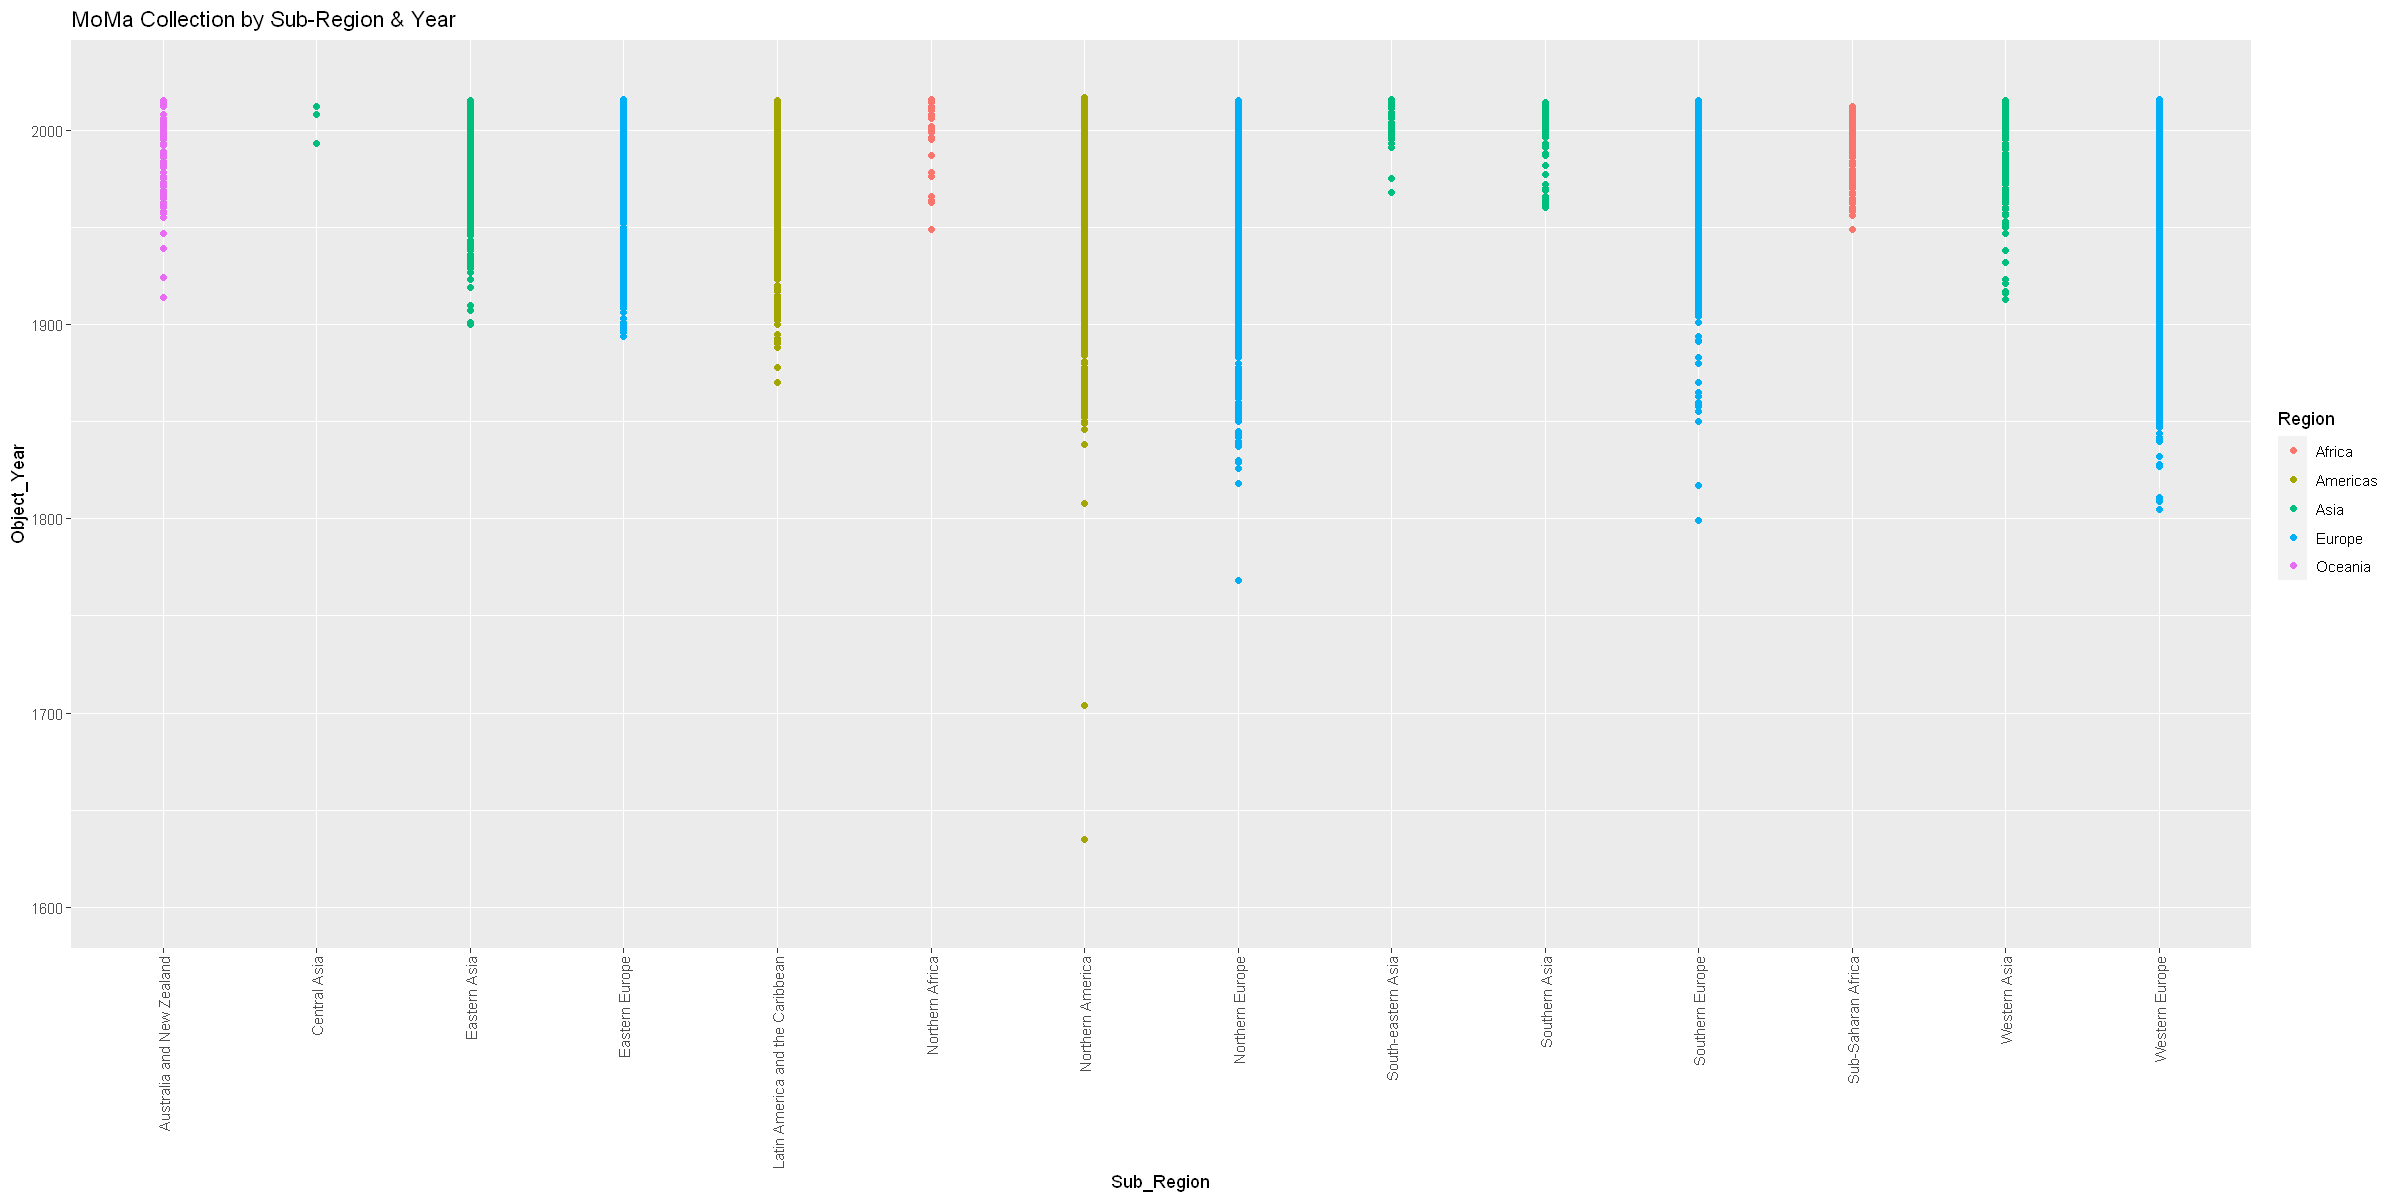

Warning message:
"Removed 2454 rows containing missing values (`geom_point()`)."


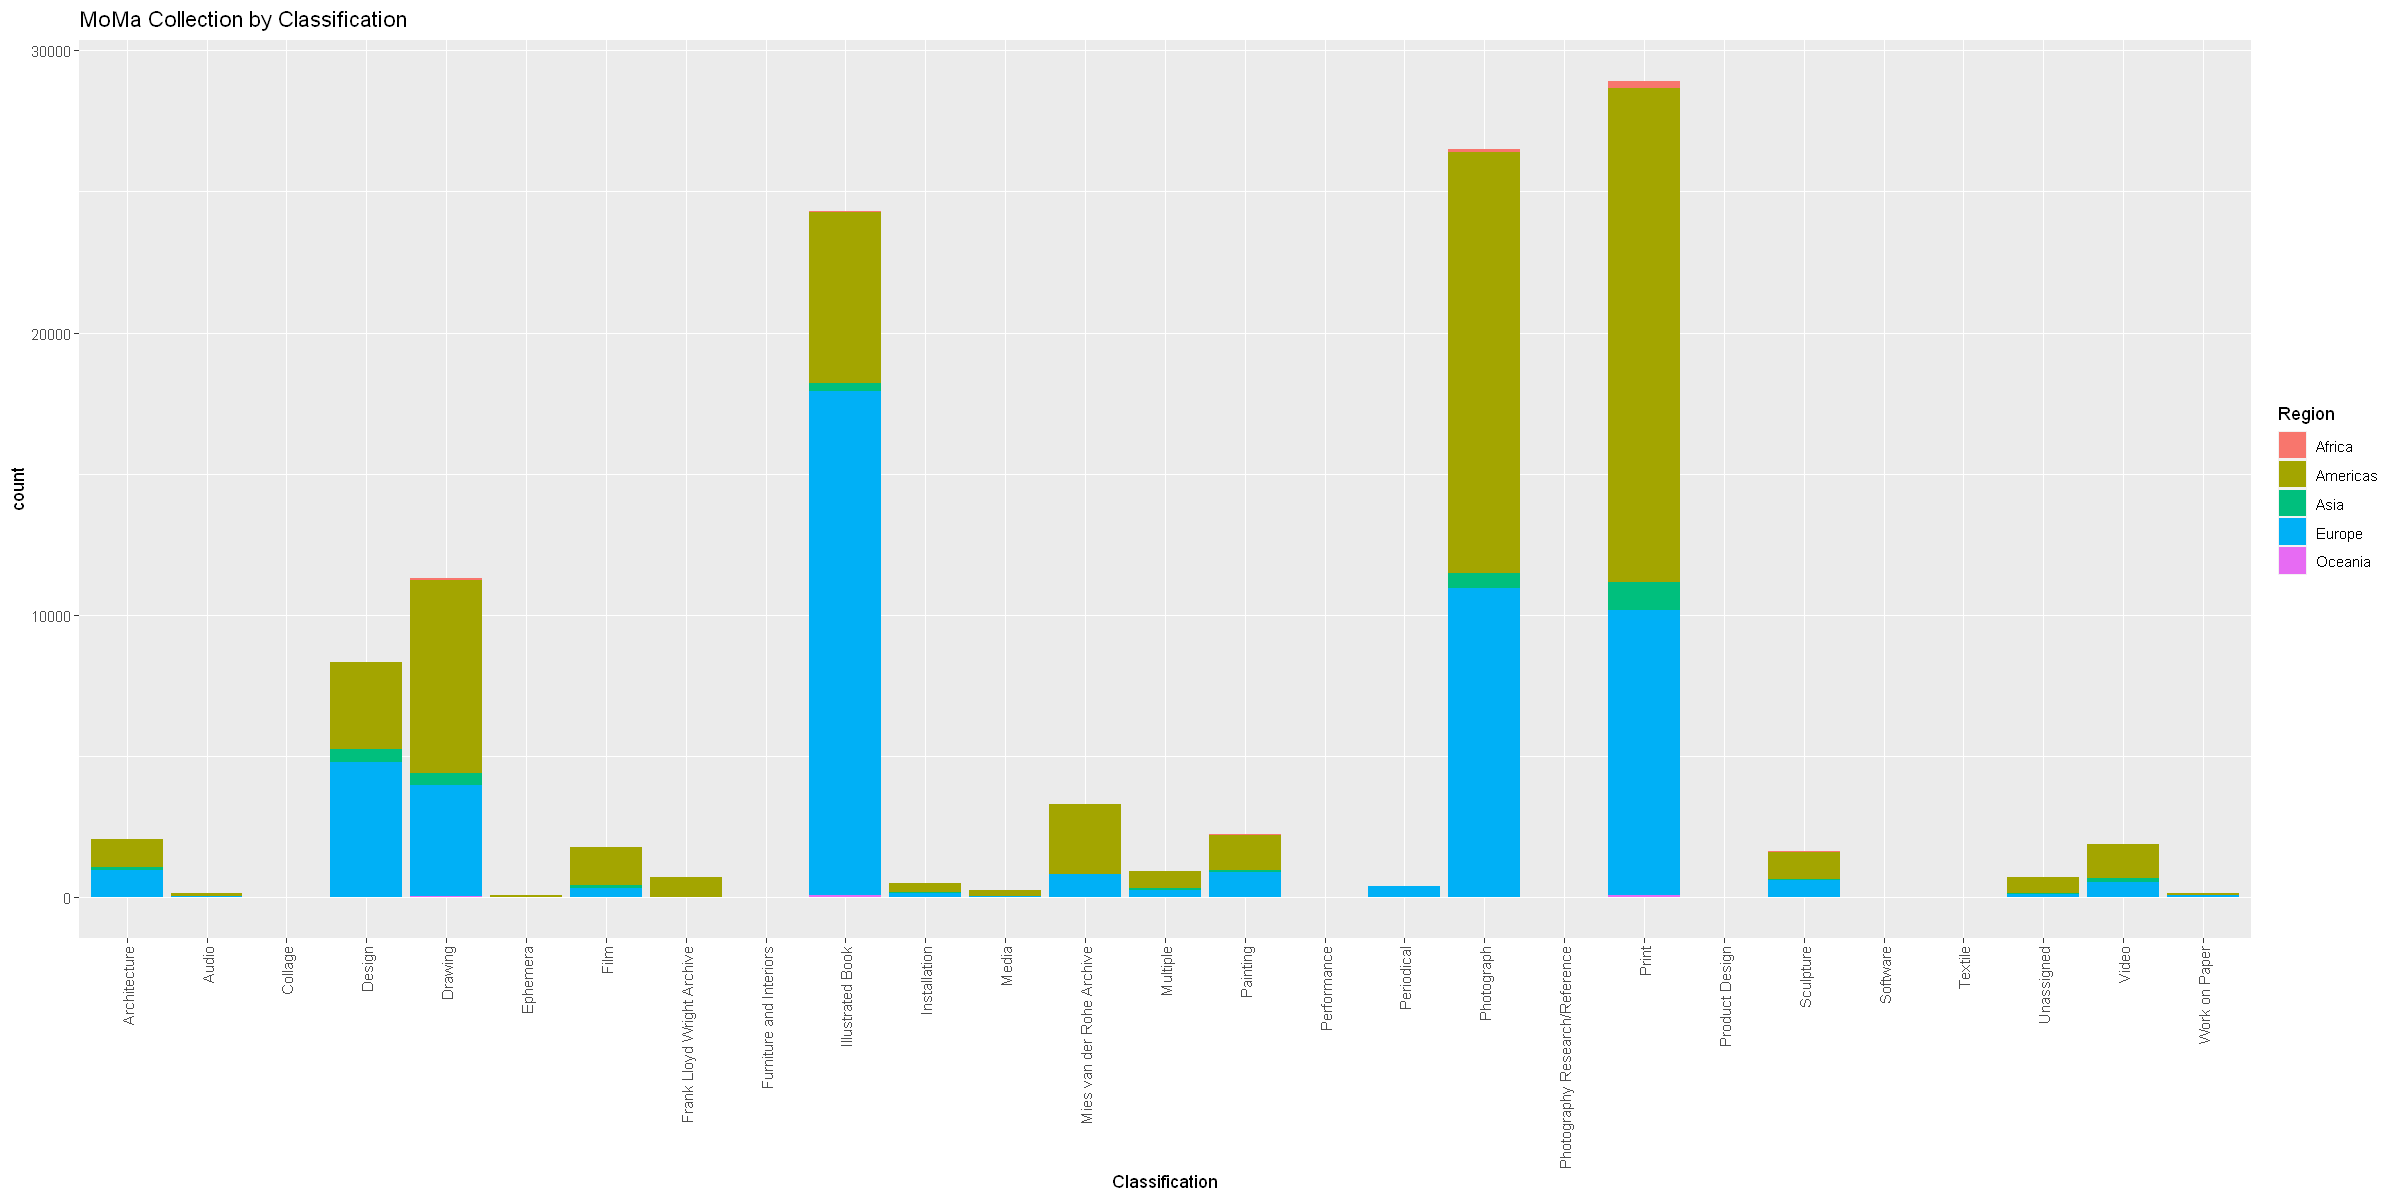

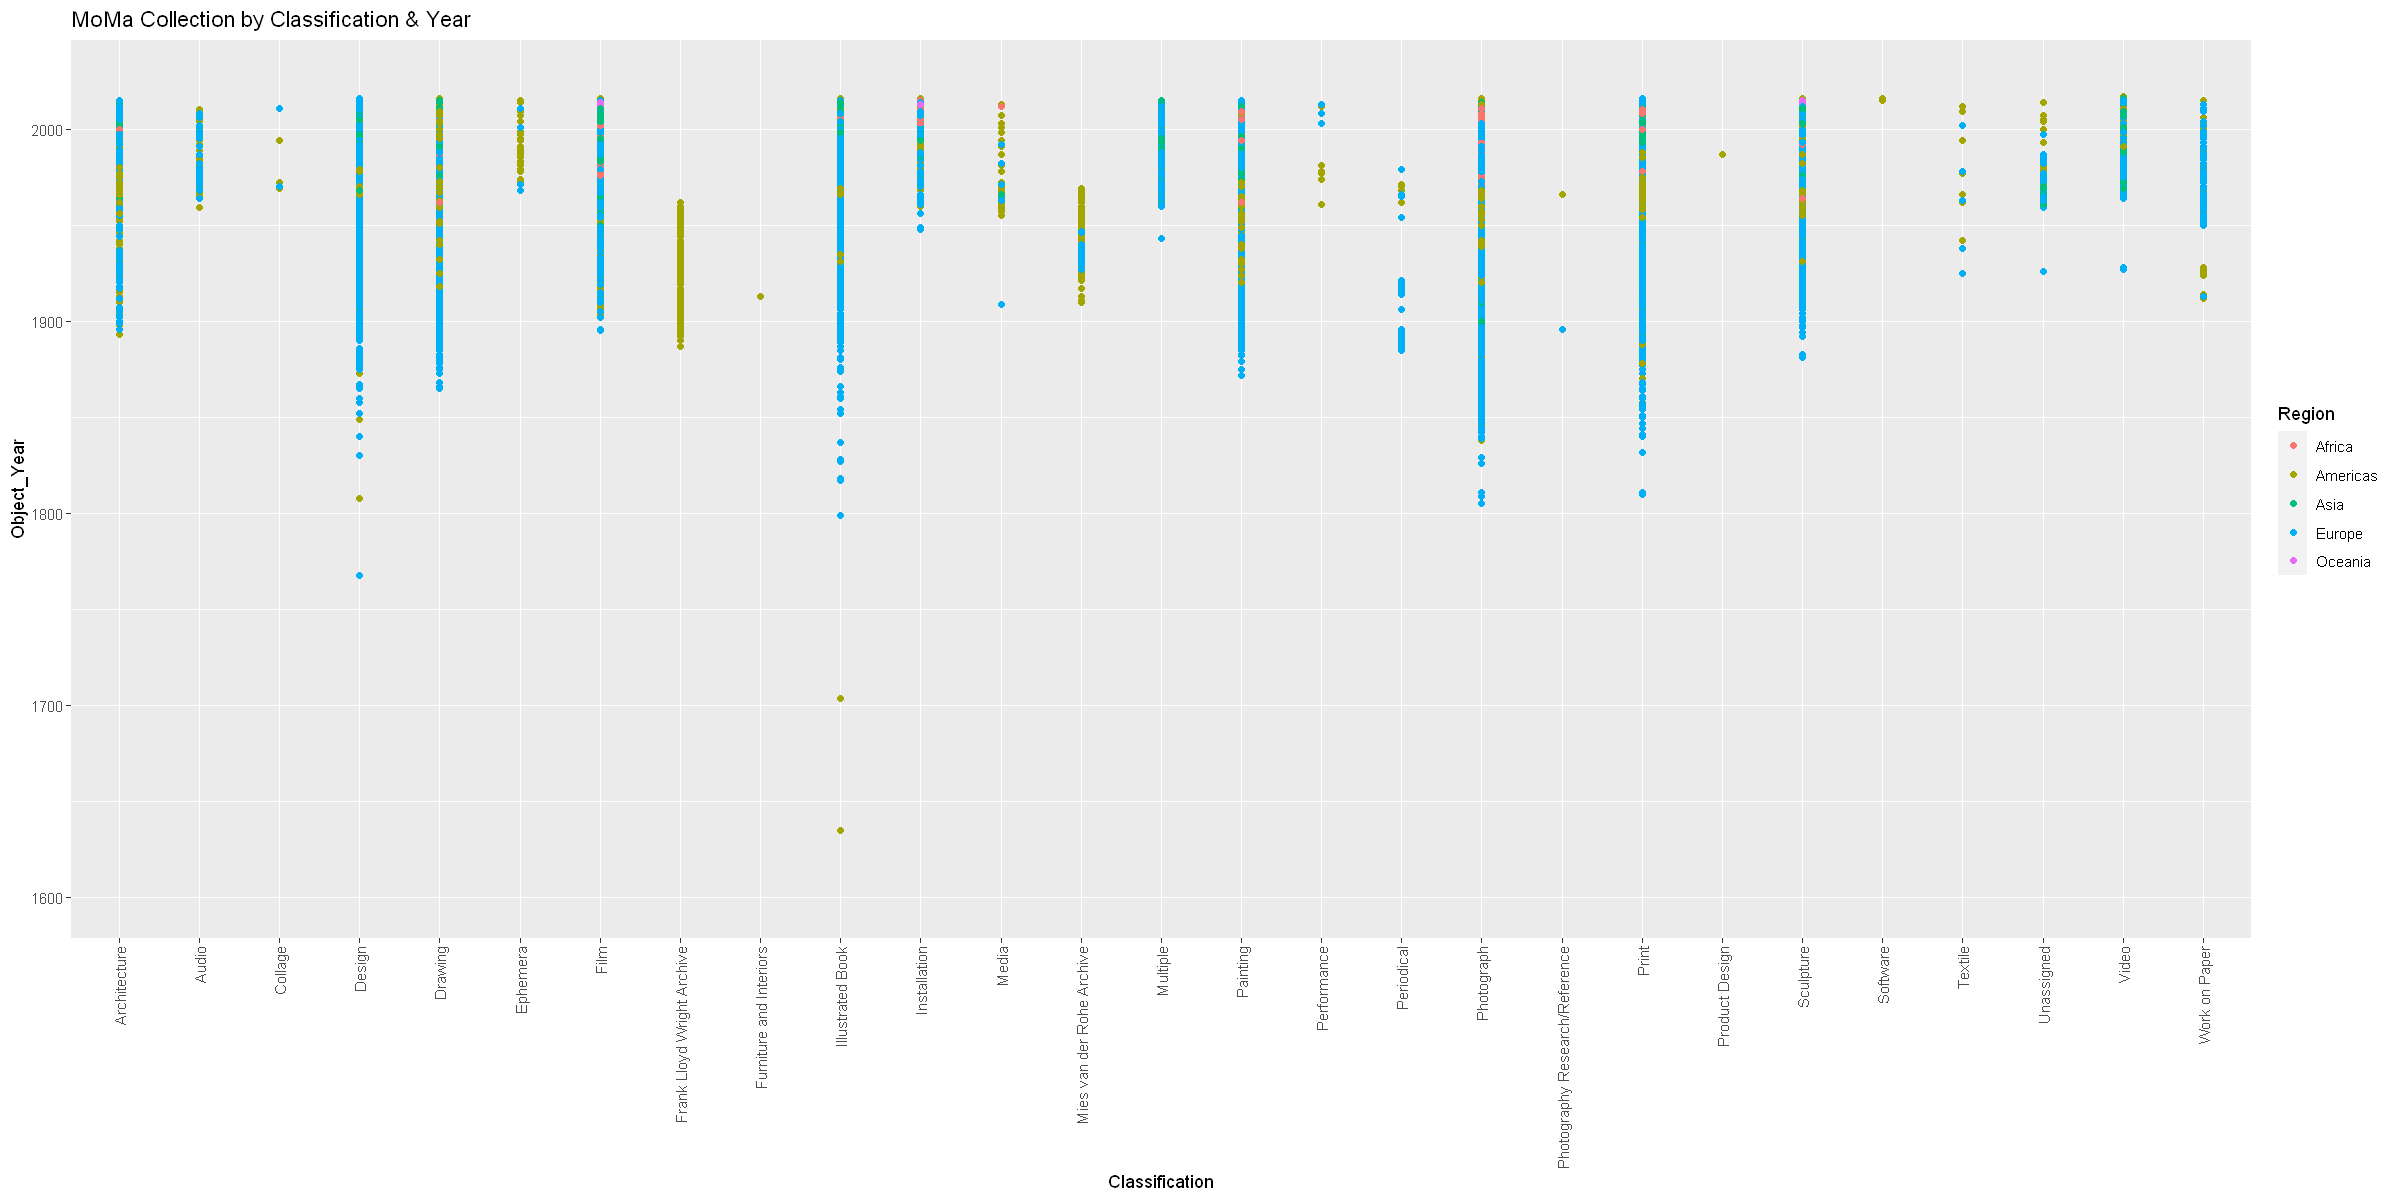

Warning message:
"Removed 2532 rows containing missing values (`geom_point()`)."


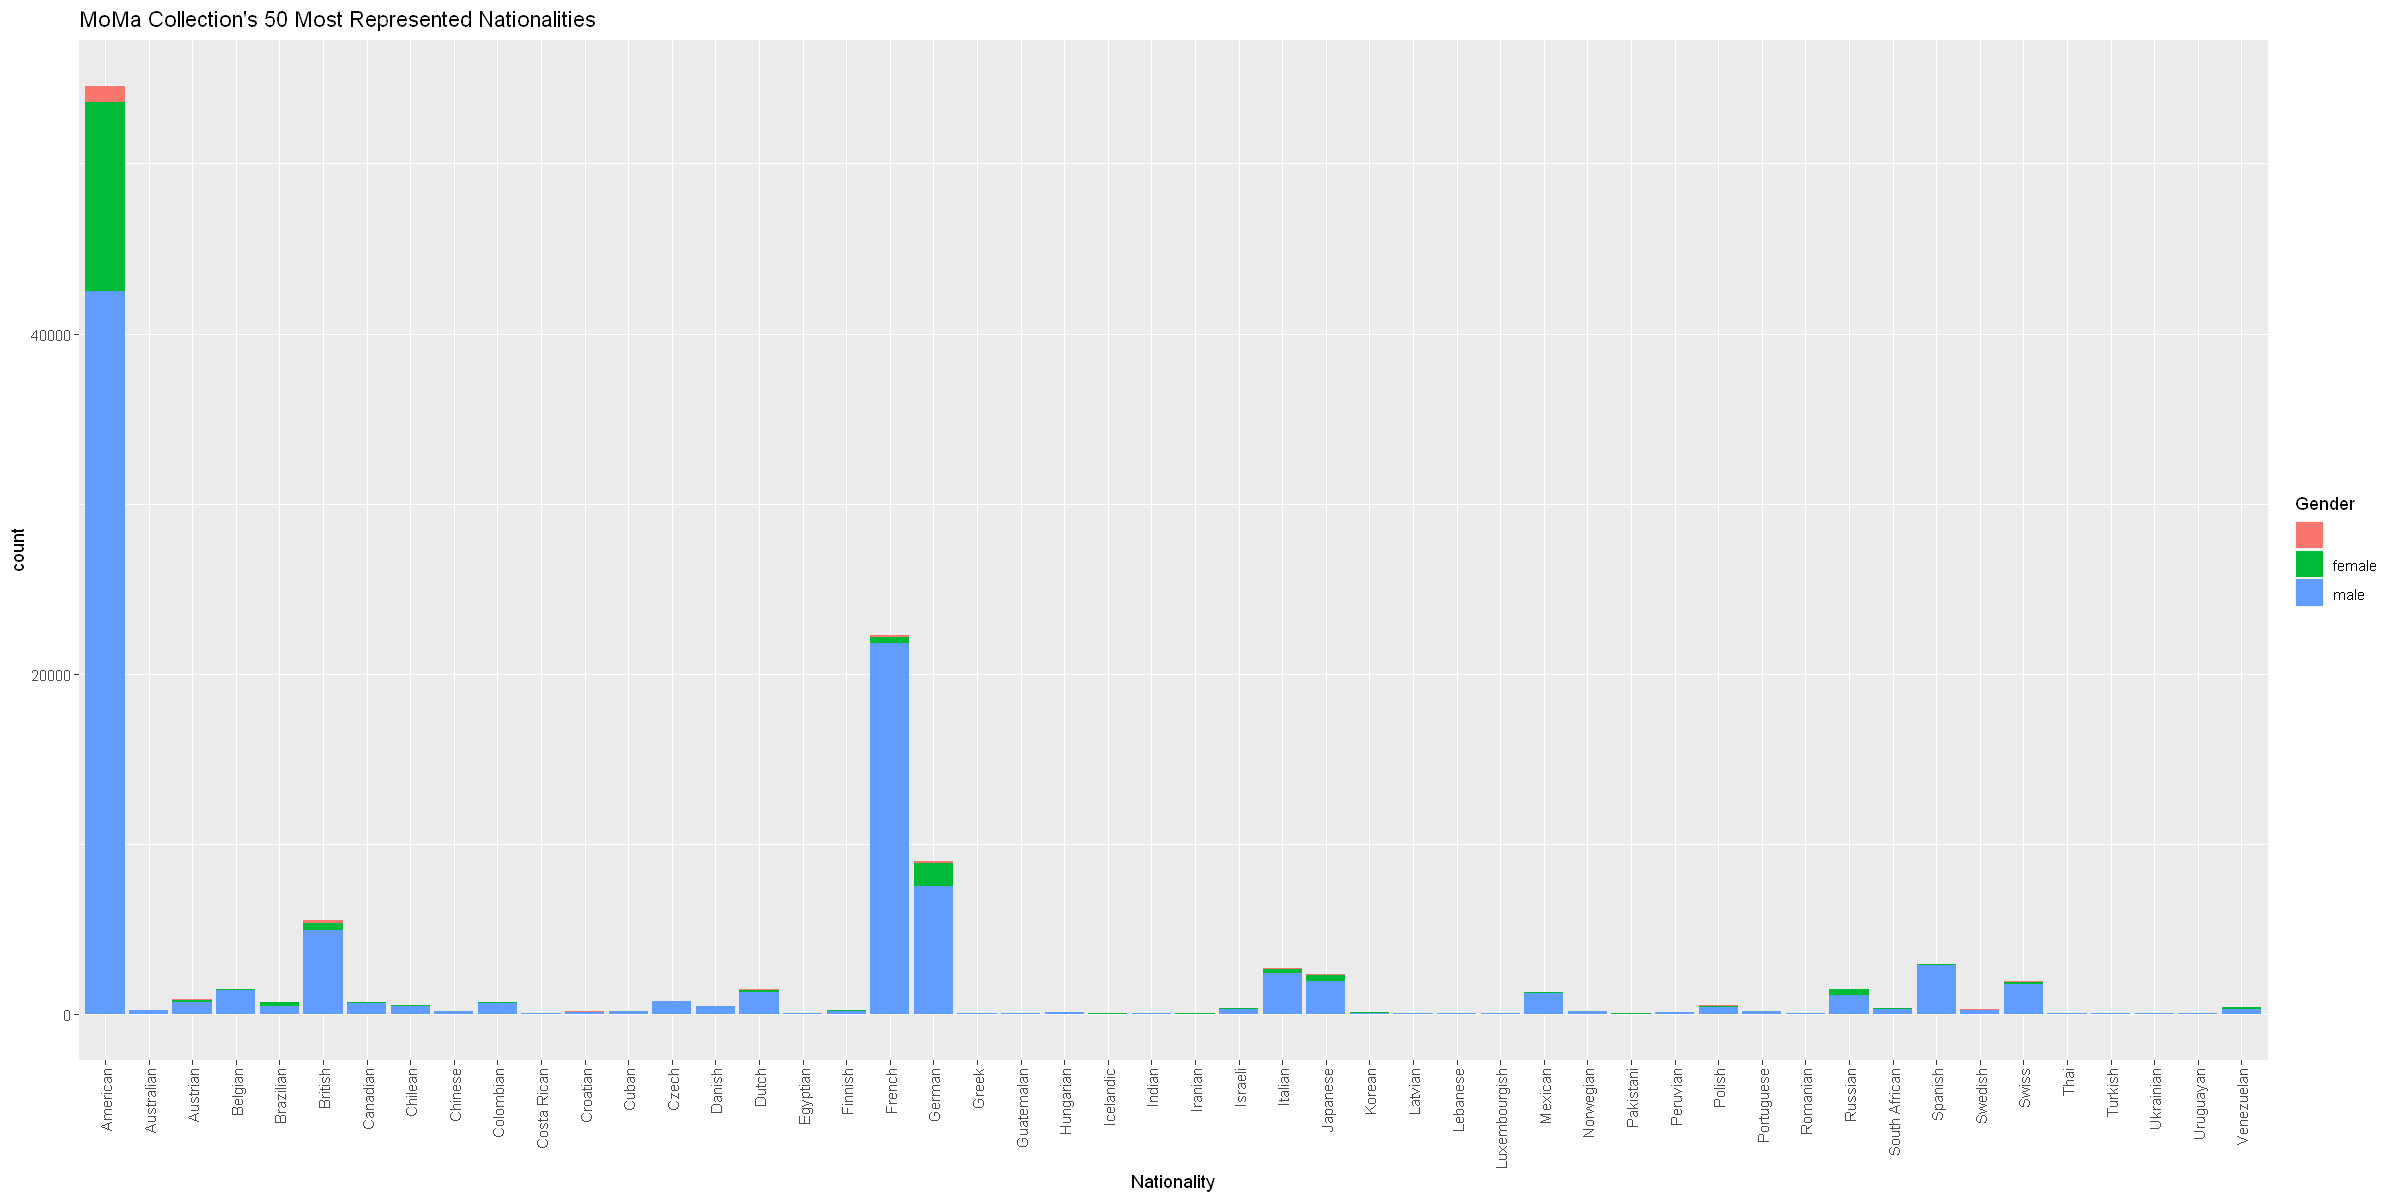

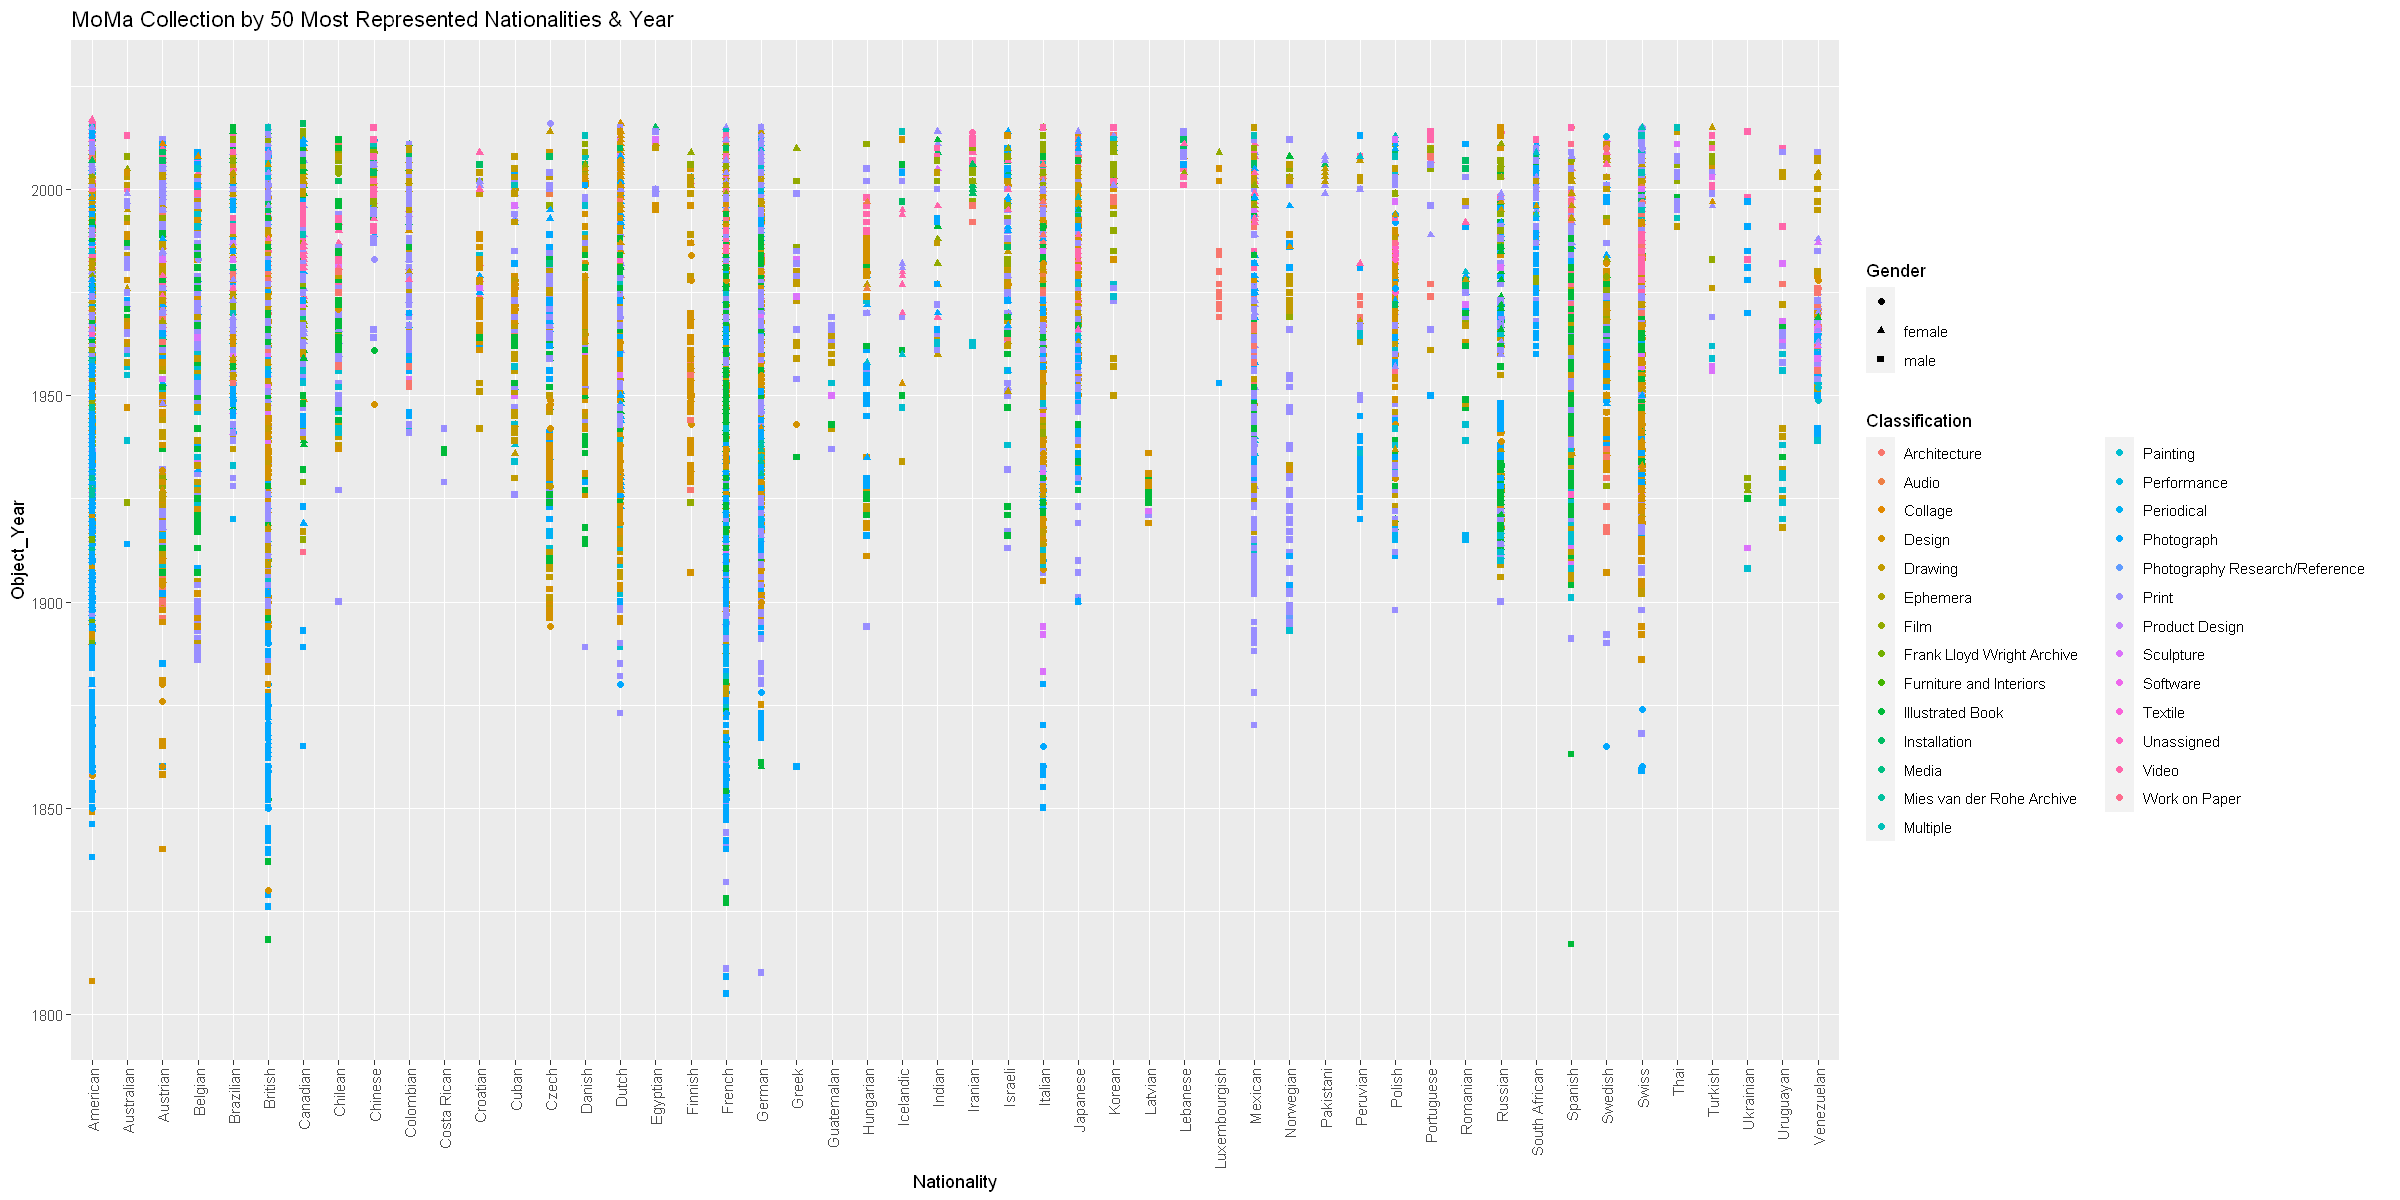

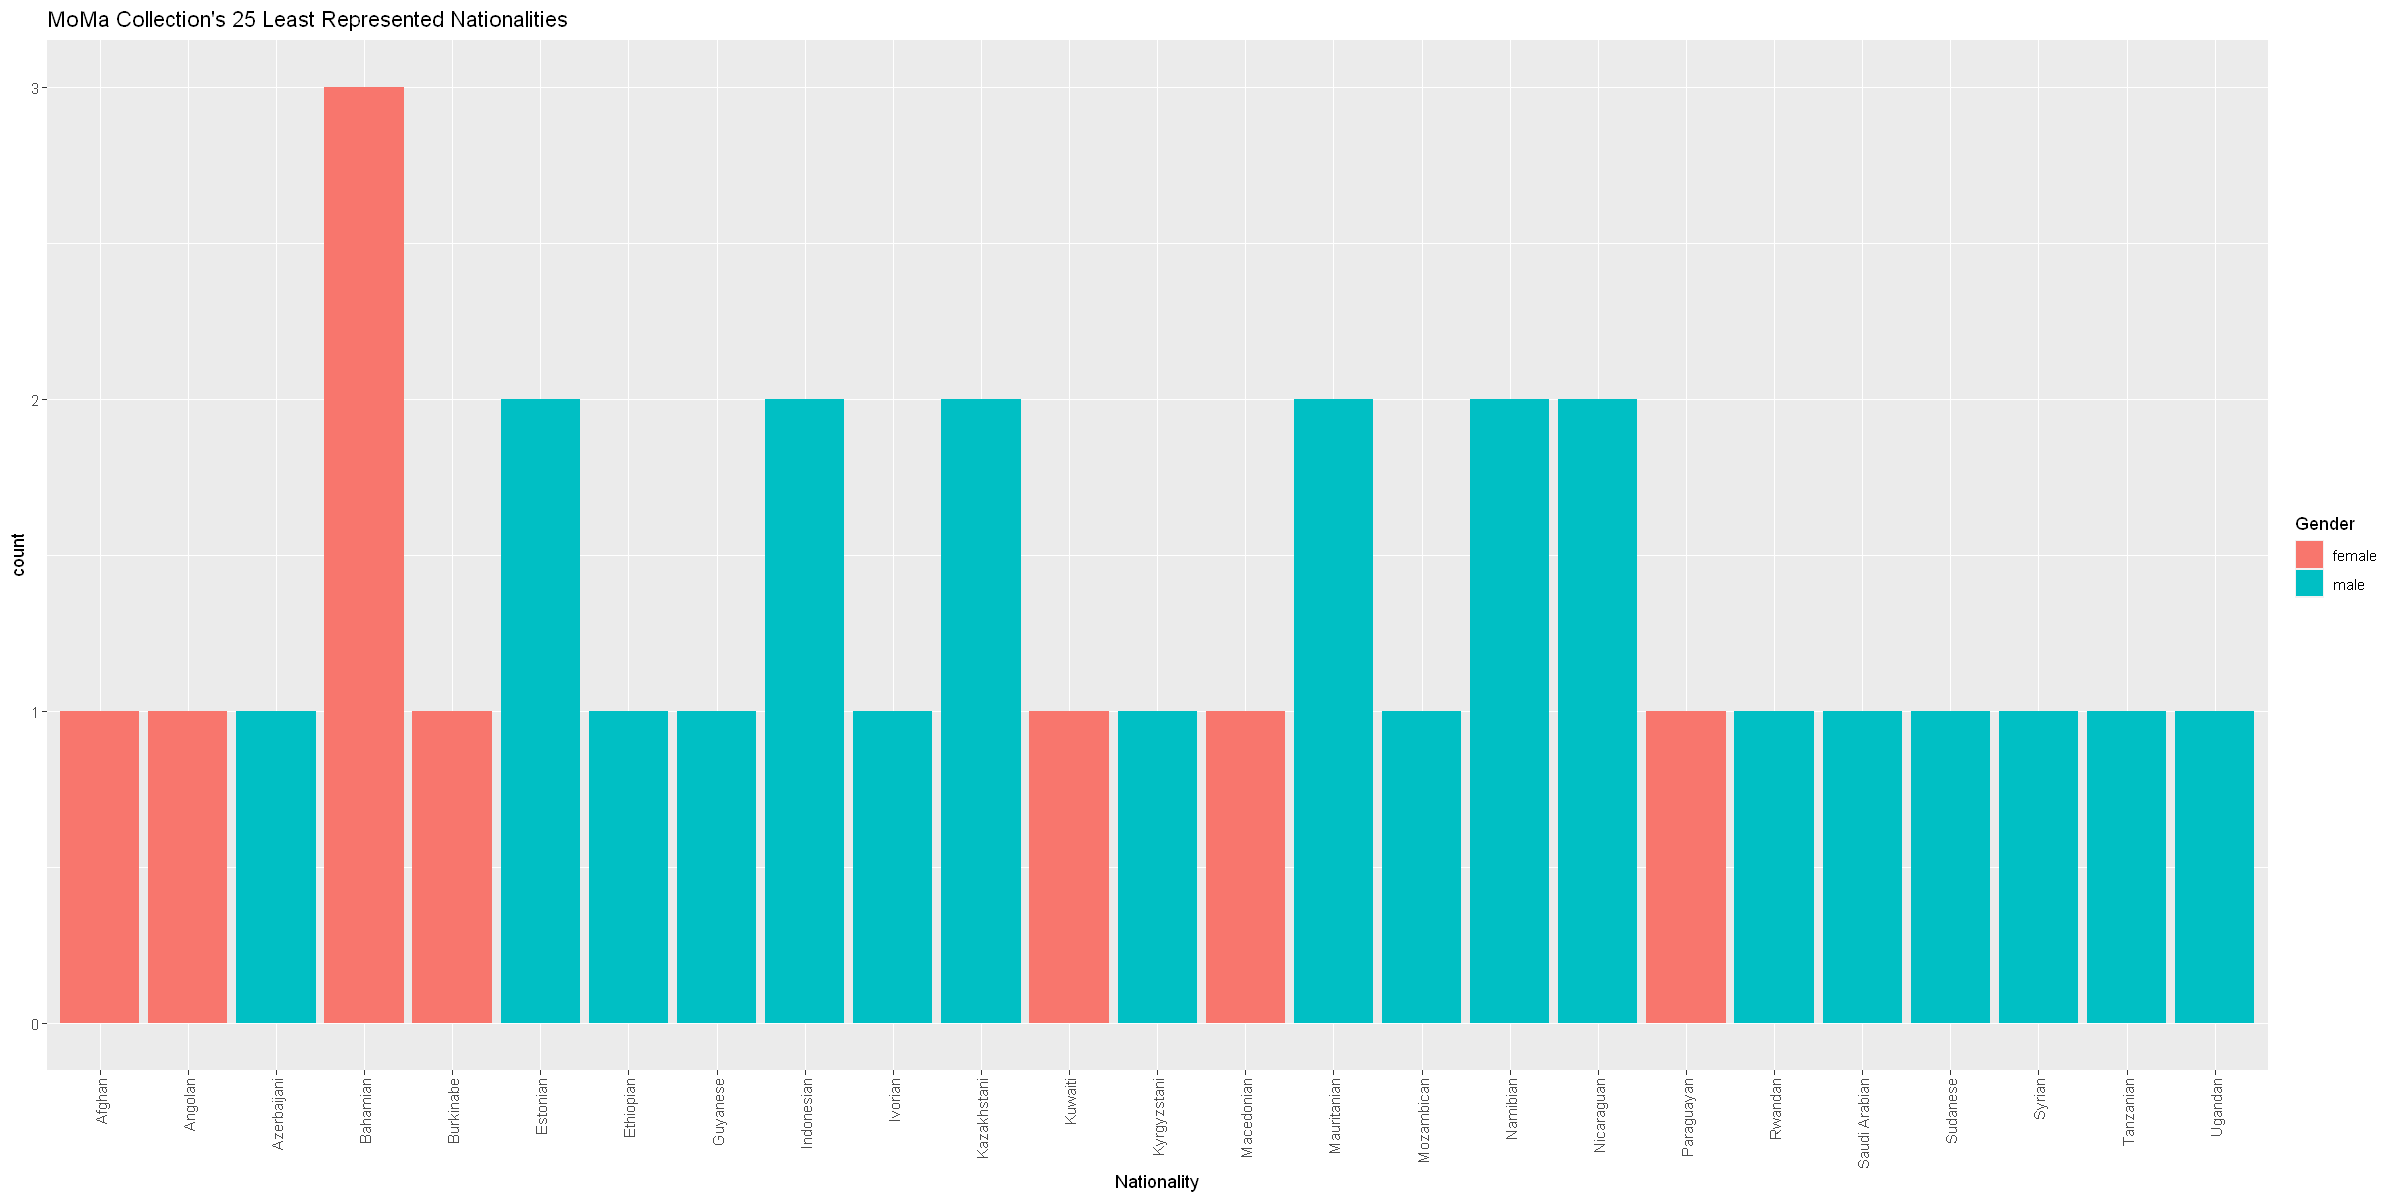

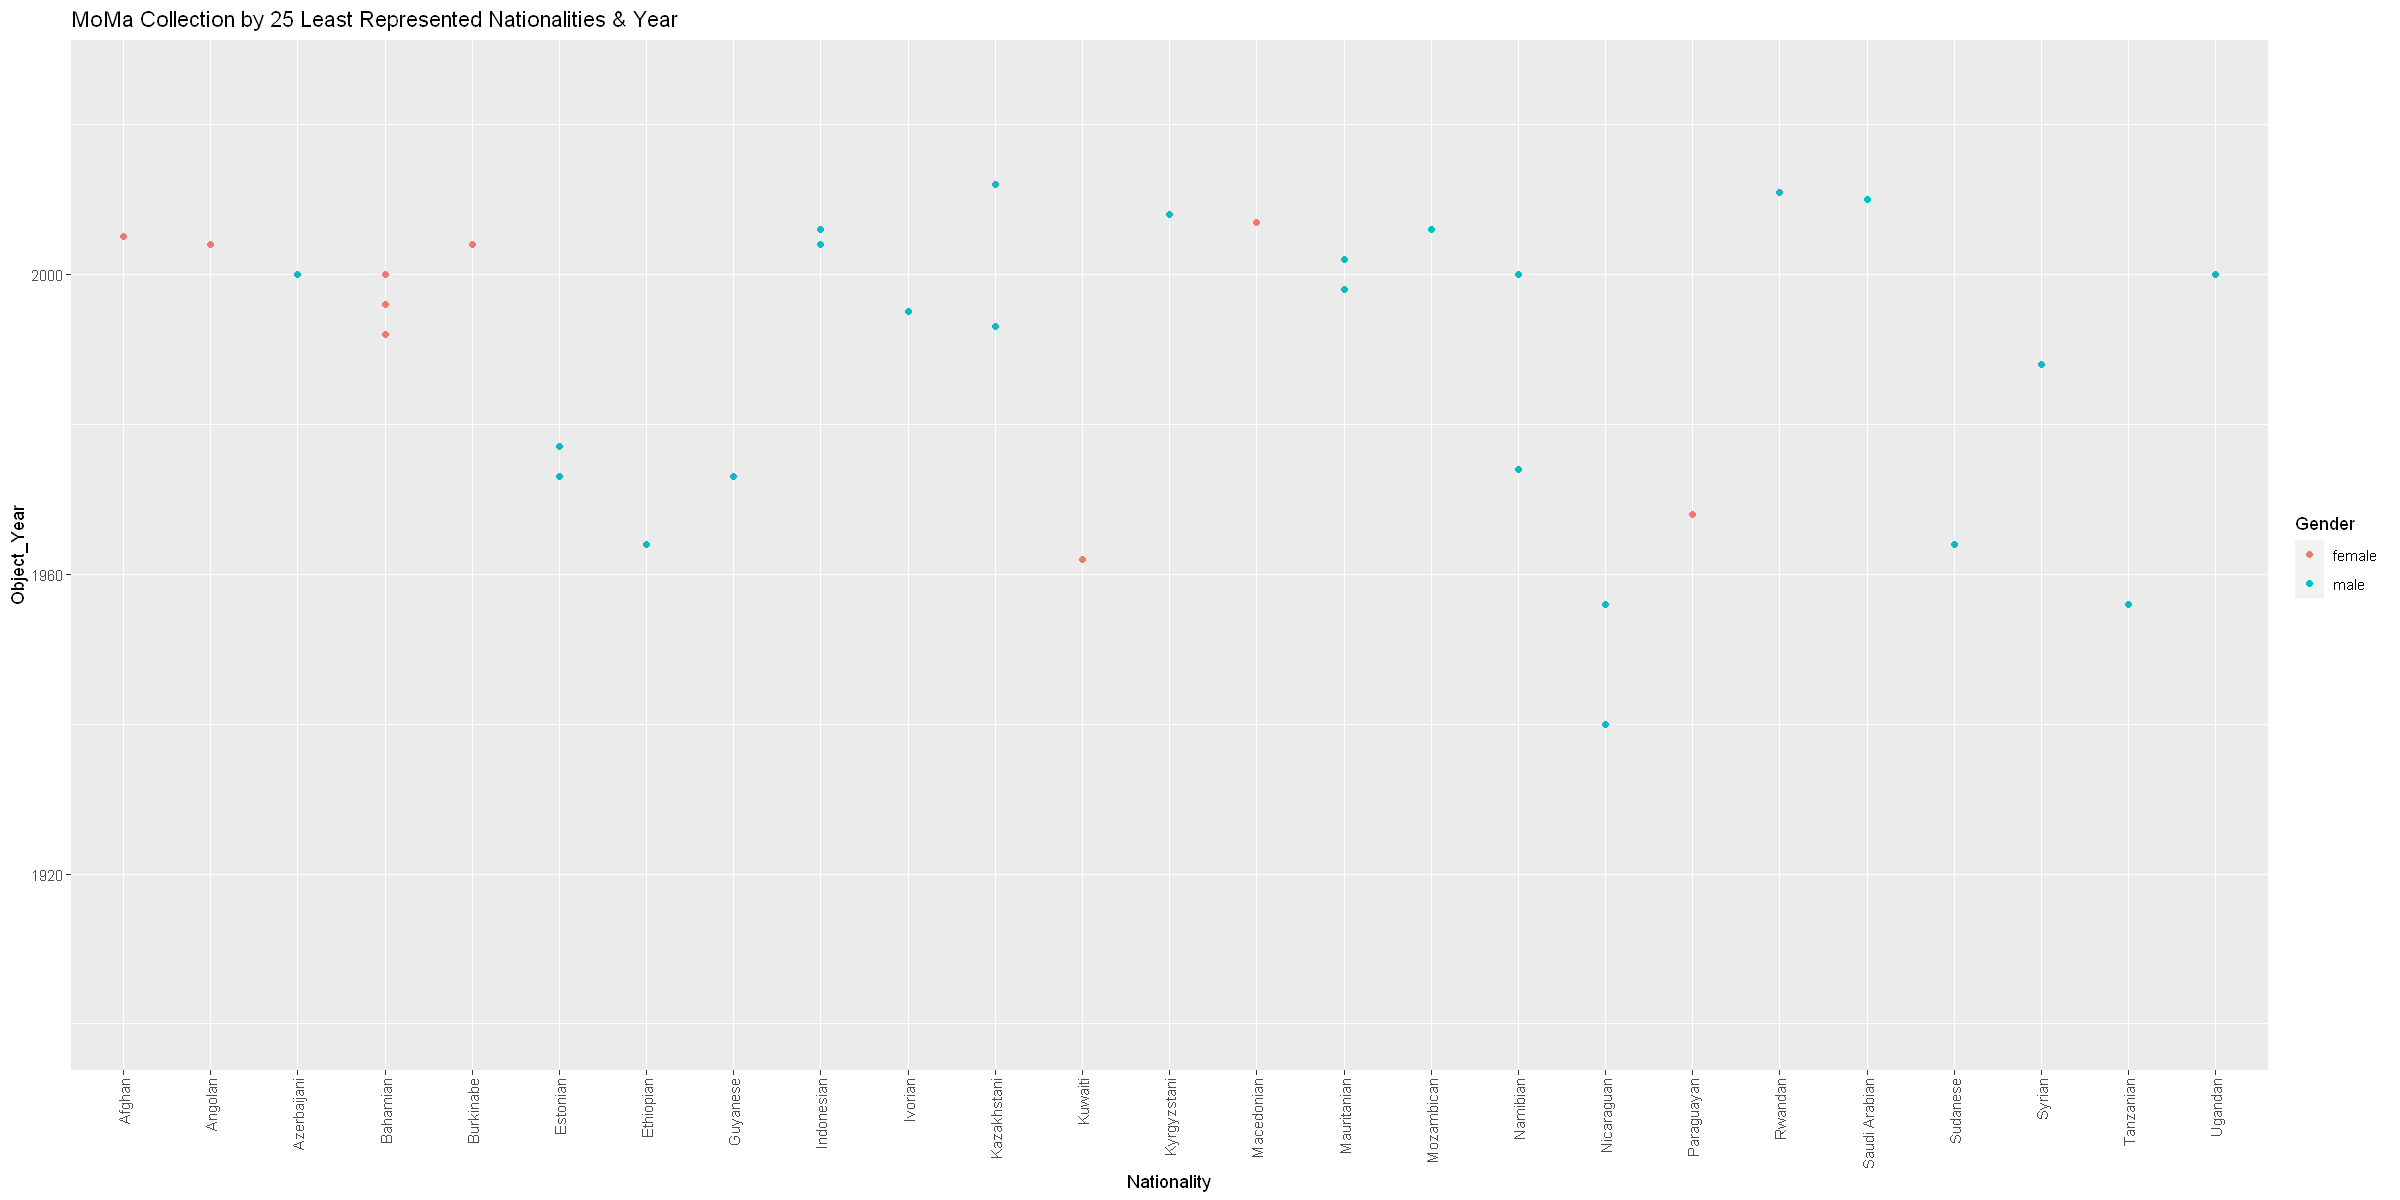

In [16]:
# --- --- --- --- --- --- --- --- --- --- --- #
#  -   -  -   Data Visualizations    -  -  -  #
# --- --- --- --- --- --- --- --- --- --- --- #

options(repr.plot.width=20, repr.plot.height=10)

# --- Plot DF on 'Region'
ggplot(data=moma_df)+
    geom_bar(mapping=aes(x=Region, fill=Gender))+
    labs(title="MoMa Collection by Region")+
    scale_x_discrete(guide=guide_axis(angle=90))

# --- Plot DF on 'Sub_Region'
ggplot(data=moma_df)+
    geom_bar(mapping=aes(x=Sub_Region, fill=Gender))+
    labs(title="MoMa Collection by Sub-Region")+
    scale_x_discrete(guide=guide_axis(angle=90))

ggplot(data=moma_df)+
    geom_point(mapping=aes(x=Sub_Region, y=Object_Year, color=Region))+
    labs(title="MoMa Collection by Sub-Region & Year")+
    ylim(1600, 2025)+scale_x_discrete(guide=guide_axis(angle=90))

# --- Plot DF on 'Classification'
ggplot(data=moma_df)+
    geom_bar(mapping=aes(x=Classification, fill=Region))+
    labs(title="MoMa Collection by Classification")+
    scale_x_discrete(guide=guide_axis(angle=90))

ggplot(data=moma_df)+
    geom_point(mapping=aes(x=Classification, y=Object_Year, color=Region))+
    labs(title="MoMa Collection by Classification & Year")+
    ylim(1600, 2025)+scale_x_discrete(guide=guide_axis(angle=90))

# --- 50 most represented nationalities
ggplot(data=first_50_df)+
    geom_bar(mapping=aes(x=Nationality, fill=Gender))+
    labs(title="MoMa Collection's 50 Most Represented Nationalities")+
    scale_x_discrete(guide=guide_axis(angle=90))

ggplot(data=first_50_df)+
    geom_point(mapping=aes(x=Nationality, y=Object_Year, shape=Gender, color=Classification))+
    labs(title="MoMa Collection by 50 Most Represented Nationalities & Year")+
    ylim(1800, 2025)+scale_x_discrete(guide=guide_axis(angle=90))

# --- 25 least represented nationalities
ggplot(data=last_25_df)+
    geom_bar(mapping=aes(x=Nationality, fill=Gender))+
    labs(title="MoMa Collection's 25 Least Represented Nationalities")+
    scale_x_discrete(guide=guide_axis(angle=90))

ggplot(data=last_25_df)+
    geom_point(mapping=aes(x=Nationality, y=Object_Year, color=Gender))+
    labs(title="MoMa Collection by 25 Least Represented Nationalities & Year")+
    ylim(1900, 2025)+scale_x_discrete(guide=guide_axis(angle=90))


## Credits: Data Sources

* 1. moma_artists & moma_objects datasets adapted from Museum of Modern Art (MoMA)'s data on Kaggle @ https://www.kaggle.com/datasets/momanyc/museum-collection

* 2. countries dataset adapted from Andrada's dataset, on Kaggle @ https://www.kaggle.com/datasets/andradaolteanu/country-mapping-iso-continent-region